In [1]:
!pip install earthengine-api --upgrade
!pip install geopandas
!pip install geetools
!pip install git+https://github.com/eduard-kazakov/Landsat8_LST_PSWA
!pip install git+https://github.com/eduard-kazakov/LandsatBasicUtils
!pip install git+https://github.com/eduard-kazakov/SREMPy-landsat    
!pip install pytz   


  Cloning https://github.com/eduard-kazakov/Landsat8_LST_PSWA to /tmp/pip-req-build-2bjc2z2h
  Running command git clone --filter=blob:none --quiet https://github.com/eduard-kazakov/Landsat8_LST_PSWA /tmp/pip-req-build-2bjc2z2h
  Resolved https://github.com/eduard-kazakov/Landsat8_LST_PSWA to commit 371cd92e0e7e1aa29807fc448b4f47b18cad1bbc
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/eduard-kazakov/LandsatBasicUtils to /tmp/pip-req-build-fokcnjp2
  Running command git clone --filter=blob:none --quiet https://github.com/eduard-kazakov/LandsatBasicUtils /tmp/pip-req-build-fokcnjp2
  Resolved https://github.com/eduard-kazakov/LandsatBasicUtils to commit 0f9c4af0ae134c52905907cae8236f1e4d750bb4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.3/840.3 kB 50.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirement

In [2]:
import geopandas as gpd
import ee
from shapely.geometry import shape, mapping
import ee
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from geetools import batch
import datetime
import pytz
import time

In [3]:
# Initialize the Earth Engine module.
ee.Authenticate()
ee.Initialize()

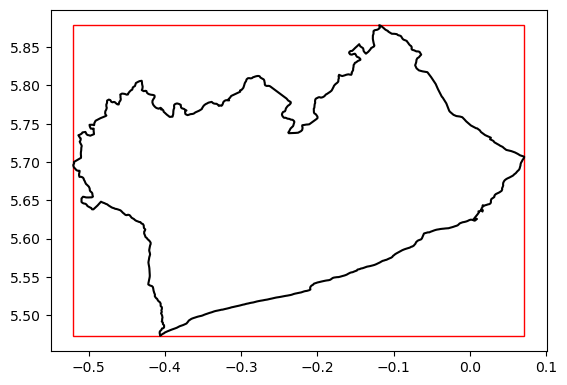

In [11]:
# Load a shapefile
shapefile = gpd.read_file('GAMA_boundary/GAMA_boundV2.shp')
# Transform GeoPandas dataframe to EPSG:4326
shapefile = shapefile.to_crs("EPSG:4326")

# Extract the min and max longitude and latitude values
minx, miny, maxx, maxy = shapefile.geometry.total_bounds

# Create a bounding box in Earth Engine
roi = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

# To validate the bbox, you can plot it using matplotlib
fig, ax = plt.subplots()

# Plot the shapefile
shapefile.boundary.plot(ax=ax, color='black')

# Add a rectangle for the bounding box
rect = Rectangle((minx, miny), maxx - minx, maxy - miny, fill=False, color='red')
ax.add_patch(rect)

# Show the plot
plt.show()

In [13]:
# Load the MODIS Terra Surface Reflectance 8-Day Global 500m product.
modis_product = 'MODIS/006/MOD09A1'

# Define a function to calculate NDVI.
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('NDVI')
    return image.addBands(ndvi)

# Define a function to calculate NDBI.
def calculate_ndbi(image):
    ndbi = image.normalizedDifference(['sur_refl_b06', 'sur_refl_b02']).rename('NDBI')
    return image.addBands(ndbi)

# Loop through the years from 2010 to 2019.
for year in range(2010, 2019 + 1):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter the collection by date and region.
    collection = ee.ImageCollection(modis_product)\
        .filterBounds(roi)\
        .filterDate(start_date, end_date)
    
    # Add NDVI and NDBI bands to the collection.
    collection = collection.map(calculate_ndvi).map(calculate_ndbi)
    
    # Calculate the mean for NDVI and NDBI over the time period.
    mean_ndvi = collection.select('NDVI').mean()
    mean_ndbi = collection.select('NDBI').mean()
    
    # Define export parameters for NDVI.
    export_params_ndvi = {
        'image': mean_ndvi,
        'description': f'MOD09A1_mean_{year}_NDVI',
        'scale': 500,  # MODIS resolution is 500m for these bands
        'region': roi.getInfo()['coordinates'],
        'fileFormat': 'GeoTIFF',
        'formatOptions': {'cloudOptimized': True}
    }
    
    # Define export parameters for NDBI.
    export_params_ndbi = {
        'image': mean_ndbi,
        'description': f'MOD09A1_mean_{year}_NDBI',
        'scale': 500,  # MODIS resolution is 500m for these bands
        'region': roi.getInfo()['coordinates'],
        'fileFormat': 'GeoTIFF',
        'formatOptions': {'cloudOptimized': True}
    }
    
    # Export the mean NDVI image.
    export_task_ndvi = ee.batch.Export.image.toDrive(**export_params_ndvi)
    export_task_ndvi.start()
    print(f"Started export task for NDVI {year} with ID: {export_task_ndvi.id}")
    
    # Export the mean NDBI image.
    export_task_ndbi = ee.batch.Export.image.toDrive(**export_params_ndbi)
    export_task_ndbi.start()
    print(f"Started export task for NDBI {year} with ID: {export_task_ndbi.id}")

# Note: Monitoring the export tasks is removed for brevity. Check the tasks' progress in the GEE Code Editor.


Started export task for NDVI 2010 with ID: SVTBPKMIHIKJ34NHXO2U44HU
Started export task for NDBI 2010 with ID: EB4PL7EK5JM2J6BJ3RMN2QVQ
Started export task for NDVI 2011 with ID: 2PLCZNA5PHIORNQONJFTI5LJ
Started export task for NDBI 2011 with ID: NP74P45WRRCBDHH7J7DM3SKJ
Started export task for NDVI 2012 with ID: GYVBW4OYUEXTJIU3LHNLNKBM
Started export task for NDBI 2012 with ID: AKILMTDF24QLG52SSFYBPRCT
Started export task for NDVI 2013 with ID: MXVTPGVZEJGQD3YZDQGRAMPZ
Started export task for NDBI 2013 with ID: 744FYBFFTVB3DVDGFMZ57OWT
Started export task for NDVI 2014 with ID: FZO6XEA3BP2P3NCWO7G32QMU
Started export task for NDBI 2014 with ID: SNEILPWUP6DCSZF54PPEZWA5
Started export task for NDVI 2015 with ID: XST3D6KUU6MIXXOZIL56P3WD
Started export task for NDBI 2015 with ID: 5TO6APR7YV3XEKNPGIWD6D77
Started export task for NDVI 2016 with ID: JEVCZWGWH3OOY7SGZA7Y6HDK
Started export task for NDBI 2016 with ID: LMKPKDF4H27KP5XAL3PUGNQ4
Started export task for NDVI 2017 with ID: KZW67

In [9]:
# Define your date range.

year = '2010'

start_date = year+'-01-01'
end_date = year+'-12-31'

# Load the MODIS Terra Surface Reflectance 8-Day Global 500m product.
modis_product = 'MODIS/006/MOD09A1'
collection = ee.ImageCollection(modis_product)\
    .filterBounds(roi)\
    .filterDate(start_date, end_date)

# MODIS Terra Surface Reflectance Band Names (MOD09A1)
# Adjust the band names according to your needs and the specific MODIS product you are using
modis_band_names = [
    'sur_refl_b01',  # Band 1 (Red)
    'sur_refl_b02',  # Band 2 (NIR)
    'sur_refl_b03',  # Band 3 (Blue)
    'sur_refl_b04',  # Band 4 (Green)
    'sur_refl_b05',  # Band 5
    'sur_refl_b06',  # Band 6
    'sur_refl_b07',  # Band 7
    # Add or remove bands as needed
]

# Calculate the mean for each band and export
for band_name in modis_band_names:
    mean_band = collection.select(band_name).mean()
    export_params = {
        'image': mean_band,  # Export the mean band image
        'description': 'MOD09A1_mean_'+year+'_' + band_name,
        'scale': 500,  # MODIS resolution is 500m for these bands
        'region': roi.getInfo()['coordinates'],
        'fileFormat': 'GeoTIFF',
        'formatOptions': {'cloudOptimized': True}
    }
    export_task = ee.batch.Export.image.toDrive(**export_params)
    export_task.start()
    
    # Print export task ID (optional, for your tracking)
    print(f"Started export task for {band_name} with ID: {export_task.id}")

# Note: Monitoring the export tasks is removed for brevity. Check the tasks' progress in the GEE Code Editor.


Started export task for sur_refl_b01 with ID: 47UM5BB5Q7WAR3DLFHPJUA46
Started export task for sur_refl_b02 with ID: ZZYGYR2HCY3X56NPWG3NWMN7
Started export task for sur_refl_b03 with ID: 6BBGWWROPKJOS4DUGK22633X
Started export task for sur_refl_b04 with ID: D2AO2HHYW3TNLXYTKWTF54DZ
Started export task for sur_refl_b05 with ID: IUMQ3PLAYXPMGORH3GP6X4NK
Started export task for sur_refl_b06 with ID: 63XRHIHL4PYUFL3CEKHFL4VF
Started export task for sur_refl_b07 with ID: N5QCCK5W2JNRXOVBTT7SRZZE


In [8]:
# Define your date range
year = '2019'
start_date = year+'-01-01'
end_date = year+'-12-31'

# Load the MODIS Terra Land Surface Temperature 8-Day Global 1km product
modis_product = 'MODIS/006/MOD11A2'
collection = ee.ImageCollection(modis_product)\
    .filterBounds(roi)\
    .filterDate(start_date, end_date)

# MODIS Terra Land Surface Temperature Band Names (MOD11A2)
# For LST, we're interested in the daytime and nighttime temperatures
modis_band_names = [
    'LST_Day_1km',  # Daytime Land Surface Temperature
    # 'LST_Night_1km',  # Nighttime Land Surface Temperature (uncomment if needed)
]

# Calculate the mean for each band and export
for band_name in modis_band_names:
    # Convert LST from Kelvin to Celsius for better readability (optional)
    mean_band = collection.select(band_name).mean().subtract(273.15)
    export_params = {
        'image': mean_band,  # Export the mean band image
        'description': 'MOD11A2_mean_'+year+'_' + band_name,
        'scale': 1000,  # MODIS LST resolution is 1km
        'region': roi.getInfo()['coordinates'],
        'fileFormat': 'GeoTIFF',
        'formatOptions': {'cloudOptimized': True}
    }
    export_task = ee.batch.Export.image.toDrive(**export_params)
    export_task.start()
    
    # Print export task ID (optional, for your tracking)
    print(f"Started export task for {band_name} with ID: {export_task.id}")


Started export task for LST_Day_1km with ID: EAJIOV7IVWHRG2VSCWOB4GC2


In [12]:
# Load the MODIS Terra Surface Reflectance 8-Day Global 500m product.
modis_product = 'MODIS/006/MOD09A1'

# Define the model coefficients for Building Count and Building Coverage
building_count_coeffs = {'sur_refl_b01': -0.0, 'sur_refl_b02': 2.268748, 'sur_refl_b03': -1.8545785, 
                         'sur_refl_b04': 1.6324093, 'sur_refl_b05': 4.8141136, 'sur_refl_b06': -16.848734, 
                         'sur_refl_b07': 18.124434}

building_coverage_coeffs = {'sur_refl_b01': 33.335003, 'sur_refl_b02': 40.39098, 'sur_refl_b03': -11.081195, 
                            'sur_refl_b04': -21.803078, 'sur_refl_b05': 43.64257, 'sur_refl_b06': -198.75725, 
                            'sur_refl_b07': 218.77393}

# Define a function to calculate building indices
def calculate_building_indices(image):
    building_count = ee.Image(0)
    building_coverage = ee.Image(0)
    for band, coeff in building_count_coeffs.items():
        building_count = building_count.add(image.select(band).multiply(coeff))
    for band, coeff in building_coverage_coeffs.items():
        building_coverage = building_coverage.add(image.select(band).multiply(coeff))
    return image.addBands(building_count.rename('Building_Count')).addBands(building_coverage.rename('Building_Coverage'))

# Loop through the years from 2010 to 2019.
for year in range(2010, 2019 + 1):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter the collection by date and region.
    collection = ee.ImageCollection(modis_product)\
        .filterBounds(roi)\
        .filterDate(start_date, end_date)
    
    # Calculate the mean for each band over the time period.
    mean_image = collection.mean()
    
    # Calculate the band-averaged approach indices
    mean_building_count = ee.Image(0)
    mean_building_coverage = ee.Image(0)
    for band, coeff in building_count_coeffs.items():
        mean_building_count = mean_building_count.add(mean_image.select(band).multiply(coeff))
    for band, coeff in building_coverage_coeffs.items():
        mean_building_coverage = mean_building_coverage.add(mean_image.select(band).multiply(coeff))
    
    mean_building_count = mean_building_count.rename('Mean_Building_Count')
    mean_building_coverage = mean_building_coverage.rename('Mean_Building_Coverage')
    
    # Calculate the annual approach indices
    collection_with_indices = collection.map(calculate_building_indices)
    mean_annual_building_count = collection_with_indices.select('Building_Count').mean().rename('Annual_Mean_Building_Count')
    mean_annual_building_coverage = collection_with_indices.select('Building_Coverage').mean().rename('Annual_Mean_Building_Coverage')
    
    # Define export parameters for band-averaged approach
    export_params_mean_bc = {
        'image': mean_building_count,
        'description': f'MOD09A1_mean_{year}_Building_Count',
        'scale': 500,  # MODIS resolution is 500m for these bands
        'region': roi.getInfo()['coordinates'],
        'fileFormat': 'GeoTIFF',
        'formatOptions': {'cloudOptimized': True}
    }
    
    export_params_mean_bcov = {
        'image': mean_building_coverage,
        'description': f'MOD09A1_mean_{year}_Building_Coverage',
        'scale': 500,  # MODIS resolution is 500m for these bands
        'region': roi.getInfo()['coordinates'],
        'fileFormat': 'GeoTIFF',
        'formatOptions': {'cloudOptimized': True}
    }
    
    # Define export parameters for annual approach
    export_params_annual_bc = {
        'image': mean_annual_building_count,
        'description': f'MOD09A1_annual_mean_{year}_Building_Count',
        'scale': 500,  # MODIS resolution is 500m for these bands
        'region': roi.getInfo()['coordinates'],
        'fileFormat': 'GeoTIFF',
        'formatOptions': {'cloudOptimized': True}
    }
    
    export_params_annual_bcov = {
        'image': mean_annual_building_coverage,
        'description': f'MOD09A1_annual_mean_{year}_Building_Coverage',
        'scale': 500,  # MODIS resolution is 500m for these bands
        'region': roi.getInfo()['coordinates'],
        'fileFormat': 'GeoTIFF',
        'formatOptions': {'cloudOptimized': True}
    }
    
    # Export the band-averaged approach images.
    export_task_mean_bc = ee.batch.Export.image.toDrive(**export_params_mean_bc)
    export_task_mean_bc.start()
    print(f"Started export task for Band-averaged Building Count {year} with ID: {export_task_mean_bc.id}")
    
    export_task_mean_bcov = ee.batch.Export.image.toDrive(**export_params_mean_bcov)
    export_task_mean_bcov.start()
    print(f"Started export task for Band-averaged Building Coverage {year} with ID: {export_task_mean_bcov.id}")
    
    # Export the annual approach images.
    export_task_annual_bc = ee.batch.Export.image.toDrive(**export_params_annual_bc)
    export_task_annual_bc.start()
    print(f"Started export task for Annual Building Count {year} with ID: {export_task_annual_bc.id}")
    
    export_task_annual_bcov = ee.batch.Export.image.toDrive(**export_params_annual_bcov)
    export_task_annual_bcov.start()
    print(f"Started export task for Annual Building Coverage {year} with ID: {export_task_annual_bcov.id}")

Started export task for Band-averaged Building Count 2010 with ID: CUX67SSQYQDZX4FF4WVDN5HA
Started export task for Band-averaged Building Coverage 2010 with ID: EMRME4PH3U6PFSA2GJT5OFT4
Started export task for Annual Building Count 2010 with ID: ATGX47ZVZY7DBYKI4WWKO3G2
Started export task for Annual Building Coverage 2010 with ID: PZXBSSCV3ULZSKYFHNT5VQSG
Started export task for Band-averaged Building Count 2011 with ID: LRJ7VGFJNBGCCHL7Y442BQZV
Started export task for Band-averaged Building Coverage 2011 with ID: AUWRVKQL4A6KGJDH7SOV7WLF
Started export task for Annual Building Count 2011 with ID: CVOZXR3WY6S7CVWTEDDWII5W
Started export task for Annual Building Coverage 2011 with ID: EMEXDNXVXU6UIN35QUUWAGCK
Started export task for Band-averaged Building Count 2012 with ID: IRTAMBTYXSEPPOZDMDW5EOVN
Started export task for Band-averaged Building Coverage 2012 with ID: DKXTHFFMSE6SAVCP7WQDPJH7
Started export task for Annual Building Count 2012 with ID: LBFJXHZEPXQJ3R5GI7R4UFLD
Started 